In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
import os
import sys
import json
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
w_dir

'/work/nlu_IR'

In [3]:
sys.path.append(w_dir+'/nlu_IR')

In [4]:
from nlu_IR import config
from nlu_IR import std

In [5]:
data = std.json_load(config.COS_DEV)

In [6]:
data[0]['QUESTIONS'][0]['QTEXT_CN']

'特穆拉·莫里森演什么电影？'

In [7]:
from nlu_IR.lucene_search.cosQA_search import CosQASearcher
from nlu_IR.evaluation.eval import eval_sp

In [8]:
mySearcher = CosQASearcher('zh')

In [9]:
mySearcher.search('特穆拉·莫里森演什么电影？', 5)

[('Q2155524',
  'River Queen',
  '河皇后是2005年由文森特·沃德执导，萨曼莎·莫顿、基弗·萨瑟兰、克里夫·柯蒂斯、特穆拉·莫里森和斯蒂芬·雷亚主演的新西兰-英国战争戏剧电影。这部电影的评价参差不齐，但在新西兰的票房表现良好。',
  7.7007856369018555),
 ('Q1184001',
  'What a Girl Wants',
  '女孩想要什么可以指：“女孩想要什么”（克里斯蒂娜·阿奎莱拉之歌），1999女孩想要什么（电影），由阿曼达·拜恩斯主演的2003年电影“女孩想要什么”（B2K之歌），2003年“女孩想要什么”，一首4分钟前为穆齐克创作的歌',
  7.653810977935791),
 ('Q529851',
  'Temuera Morrison',
  '特穆拉·德里克·莫里森（1960年12月26日出生）是新西兰演员，他在新西兰肥皂剧《肖特兰街》（Shortland Street）中扮演的Hone Ropata博士首次获得认可。他在1994年的电影《曾经是勇士》和1999年的续集《伤心的人是什么》中饰演杰克·海克，获得了评论界的好评？。他在《星球大战：第二集克隆人的进攻》（2002年）和《星球大战：第二集克隆人的进攻》和《星球大战：第三集西斯的复仇》（2005年）中扮演了詹戈·费特（Jango Fett），从而在国际上享有盛名。他还因在《莫阿纳》（2016）中饰演片名人物之父的崔局长以及在《阿奎曼》（2018）中饰演亚瑟·柯里的父亲托马斯而闻名。',
  7.634599208831787),
 ('Q3536311',
  'Tracker (2011 film)',
  '跟踪器是一部2011年英国-新西兰动作惊悚片，由伊恩·夏普执导，雷·温斯顿和特穆拉·莫里森主演。它设定在1903年的新西兰。',
  7.125396251678467),
 ('Q1759154',
  'The Beautiful Country',
  '美丽的国家是一部以1990年为背景的2004年戏剧电影。这部电影由汉斯·佩特·莫兰执导，达米安·阮、尼克·诺尔特、白玲、周铁金玄、蒂姆·罗斯、安·图、特穆拉·莫里森和约翰·侯赛因主演。剧本由萨比娜·默里（Sabina Murray）根据默里和特伦斯·马利克（Te

# inspect_cosqa

In [72]:
def inspect_cosqa(data):
    num_gold_sp = 0
    valid_questions = []
    invalid_questions = []
    gold_sp_nums = []
    gold_sp_num_dict = {}
    for d_i, d in enumerate(tqdm(data)):
        for question in d['QUESTIONS']:
            try:
                gold_sp = question['SHINT_']
                num_gold_sp += len(gold_sp)
                if len(gold_sp) not in gold_sp_num_dict:
                    gold_sp_num_dict[len(gold_sp)] = 1
                else:
                    gold_sp_num_dict[len(gold_sp)] += 1
                gold_sp_nums.append(len(gold_sp))
                valid_questions.append(d)
            except Exception as e:
                invalid_questions.append(d)
                continue
    print("average_gold_sp:{}".format(num_gold_sp/len(valid_questions)))
    print("Valid data:{}".format(len(valid_questions)))
    print("Invalid data:{}".format(len(invalid_questions)))
    print("max sp_num:{}".format(max(gold_sp_nums)))
    print("min sp_num:{}".format(min(gold_sp_nums)))
    
    gold_sp_num_list = [(k, v) for k, v in gold_sp_num_dict.items()]
    gold_sp_num_list.sort(key=lambda x: x[0])
    return gold_sp_num_list

In [11]:
train_data = std.json_load(config.COS_TRAIN)
dev_data = std.json_load(config.COS_DEV)
test_data = std.json_load(config.COS_TEST)

# IR Search

In [89]:
def search_batch(q_texts, searcher, top_n):
    predictions = []
    
    for q_text in tqdm(q_texts):
        prediction = searcher.search(q_text, top_n)
        predictions.append([p[0] for p in prediction])
    return predictions

In [92]:
def eval_cosqa(data, top_n):
    searcher_cn = CosQASearcher('zh')
    searcher_en = CosQASearcher('en')
    
    cn_q_texts = []
    en_q_texts = []
    golds = []
    cn_predictions = []
    en_predictions = []
    for d in tqdm(data):
        for question in d['QUESTIONS']:
            if len(question['SHINT_']) == 0:
                continue
            prediction_cn = searcher_cn.search(question['QTEXT_CN'], top_n)
            prediction_en = searcher_en.search(question['QTEXT'], top_n)
            
            cn_pred_doc_ids = [p[0] for p in prediction_cn]
            cn_predictions.append(cn_pred_doc_ids)
            en_pred_doc_ids = [p[0] for p in prediction_en]
            en_predictions.append(en_pred_doc_ids)
            golds.append(question['SHINT_'])
            
            
    #search
#     cn_predictions = search_batch(cn_q_texts, searcher_cn, top_n)
#     en_predictions = search_batch(en_q_texts, searcher_en, top_n)
    
    print("cn: {}".format(eval_sp(golds, cn_predictions)))
    print("en: {}".format(eval_sp(golds, en_predictions)))

# IR performance

In [94]:
# eval_cosqa(dev_data, 10)

In [95]:
eval_cosqa(dev_data, 60)

AssertionError: 

In [29]:
num_sp_list_train = inspect_cosqa(train_data)
num_sp_list_dev = inspect_cosqa(dev_data)
num_sp_list_test = inspect_cosqa(test_data)


average_gold_sp:1.7339559276809127
Valid data:21737
Invalid data:0
max sp_num:58
min sp_num:0



average_gold_sp:1.8286264441591784
Valid data:10906
Invalid data:0
max sp_num:32
min sp_num:0



average_gold_sp:1.8296915167095116
Valid data:10892
Invalid data:0
max sp_num:47
min sp_num:0


# Figure

In [18]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [31]:
len(num_sp_list_train)

28

In [38]:
def plot_num_gold_sp(num_sp_list):
    plt.figure(figsize=(80, 10))
    plt.subplot(131)
    A = plt.bar([str(num_tuple[0]) for num_tuple in num_sp_list], [num_tuple[1] for num_tuple in num_sp_list])
    createLabels(A)
    plt.title('Number of gold supporting documents')

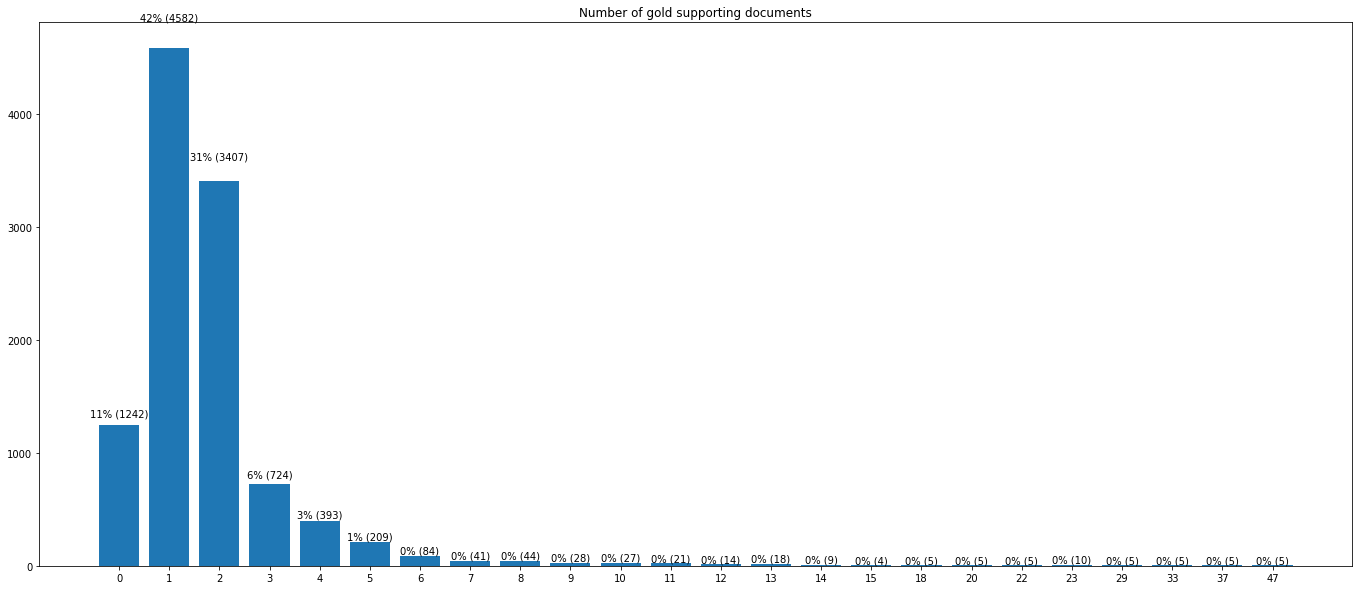

In [46]:
plot_num_gold_sp(num_sp_list_test)

In [82]:
no_sp_data = []
large_sp_data = []
for d_i, d in enumerate(tqdm(dev_data)):
    for q in d['QUESTIONS']:
        sp_num = len(q['SHINT_'])
        if sp_num == 0:
            no_sp_data.append(d_i)
        if sp_num >= 30:
            large_sp_data.append(d_i)

In [87]:
dev_data[large_sp_data[6]]

{'DID': 'wiki-entities_qa_actor_to_movie_dev_701',
 'DTEXT': 'Harvey Keitel ( ky-TEL; born May 13, 1939) is an American actor and producer. He has starred in films such as Mean Streets (1973), Taxi Driver (1976), The Duellists (1977), The Last Temptation of Christ (1988), Bugsy (1991), Thelma & Louise (1991), Reservoir Dogs (1992),  Bad Lieutenant (1992), The Piano (1993), Pulp Fiction (1994), From Dusk till Dawn (1996), Cop Land (1997), The Grand Budapest Hotel (2014), Youth (2015) and The Irishman (2019).Keitel has been nominated for a number of accolades in his career, including Academy and Golden Globe awards, and has won an Australian Academy of Cinema and Television Arts Award for Best Actor in a Leading Role for his role in The Piano. From 1995 to 2017, he was a co-president of the Actors Studio, along with actors Al Pacino and Ellen Burstyn.\nReservoir Dogs is a 1992 American independent crime film written and directed by Quentin Tarantino in his feature-length debut. It stars 

In [76]:
large_sp_data[0]

IndexError: list index out of range

In [73]:
num_sp_list_dev = inspect_cosqa(dev_data)


average_gold_sp:1.8286264441591784
Valid data:10906
Invalid data:0
max sp_num:32
min sp_num:0
